>> plotting Native Feature Importance...


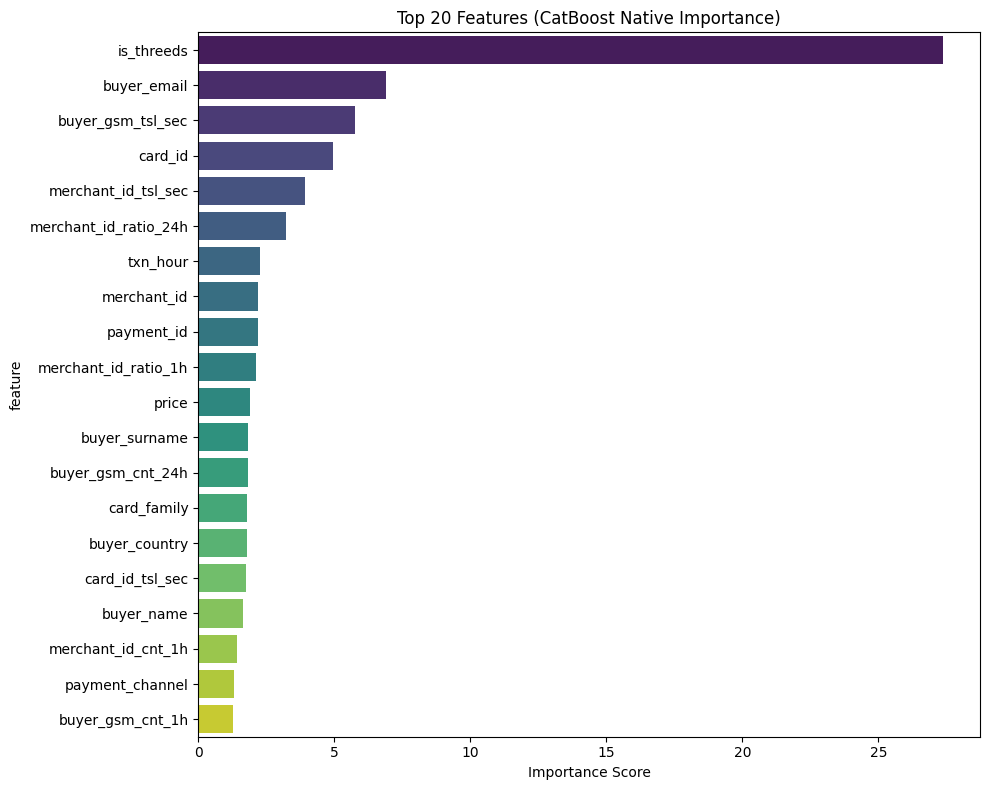


=== TOP 10 DRIVERS ===
              feature  importance
           is_threeds   27.371840
          buyer_email    6.896253
    buyer_gsm_tsl_sec    5.770011
              card_id    4.956567
  merchant_id_tsl_sec    3.924681
merchant_id_ratio_24h    3.210498
             txn_hour    2.266472
          merchant_id    2.205949
           payment_id    2.193508
 merchant_id_ratio_1h    2.104896

 running SHAP Analysis...


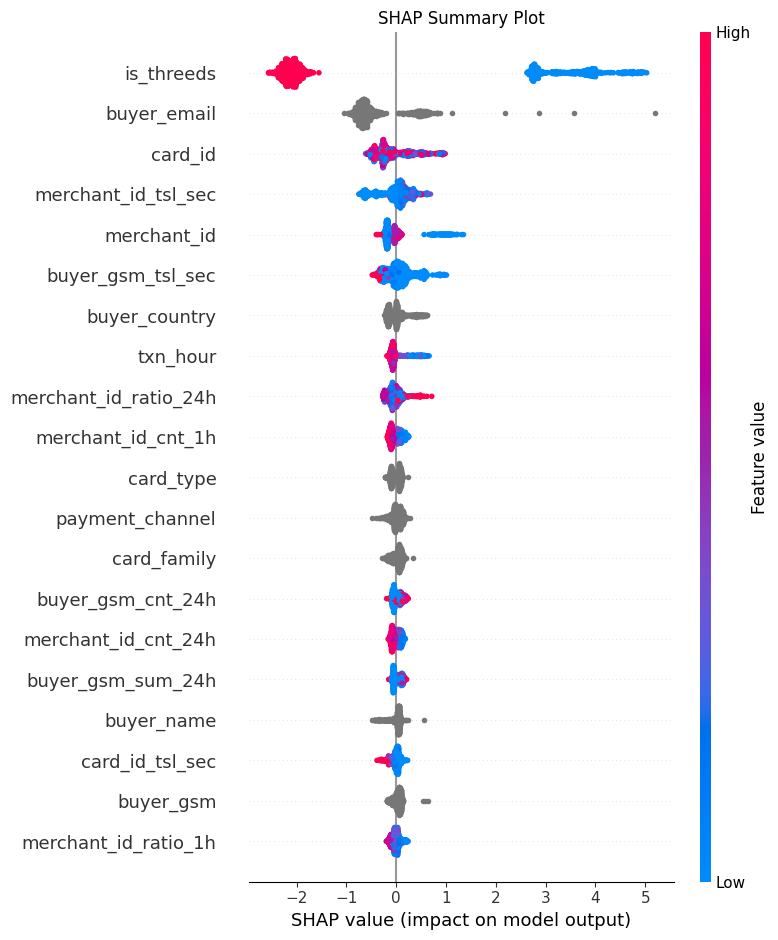


 reports saved to: ../reports


In [9]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1400)

# Paths
MODEL_DIR = "../models"
REPORT_DIR = "../reports"
DATA_PATH = "../data/processed/iyzico_featured_leakfree.csv"

MODEL_PATH = os.path.join(MODEL_DIR, "final_catboost_model.cbm")
ARTIFACT_PATH = os.path.join(MODEL_DIR, "training_artifacts.json")
FEATCOLS_PATH = os.path.join(MODEL_DIR, "feature_columns.json")

os.makedirs(REPORT_DIR, exist_ok=True)

def load_resources():
    #Loads model, artifacts and a data sample for interpretation.

    # 1. Load Schema
    with open(ARTIFACT_PATH, "r") as f:
        artifact = json.load(f)
    with open(FEATCOLS_PATH, "r") as f:
        feat_cols = json.load(f)

    # 2. Load Data (Sample)
    # Using a subset for SHAP because it's computationally expensive
    df = pd.read_csv(DATA_PATH, low_memory=False)

    # Filter for valid dates and select a random sample from Train/Valid period
    df["payment_date"] = pd.to_datetime(df["payment_date"], errors="coerce")
    df = df.dropna(subset=["payment_date"])

    # Sample 1000 rows for interpretation
    sample_df = df.sample(1000, random_state=42).reset_index(drop=True)

    # 3. Preprocess Sample (Must match training exactly)
    drop_cols = artifact["drop_cols"]
    cat_cols = artifact["cat_cols"]
    missing_cat = artifact.get("missing_cat", "MISSING")

    # Drop unused
    X = sample_df.drop(columns=[c for c in drop_cols if c in sample_df.columns])
    # Align columns
    X = X.reindex(columns=feat_cols)

    # Cast types
    for c in cat_cols:
        if c in X.columns:
            X[c] = X[c].astype("string").fillna(missing_cat)

    num_cols = [c for c in X.columns if c not in cat_cols]
    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0)

    # 4. load model
    model = CatBoostClassifier()
    model.load_model(MODEL_PATH)

    return model, X, cat_cols

def plot_native_importance(model, output_path):
    #plots CatBoost's built-in feature importance

    importance = model.get_feature_importance(type="FeatureImportance")
    names = model.feature_names_

    df_imp = pd.DataFrame({"feature": names, "importance": importance})
    df_imp = df_imp.sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x="importance", y="feature", hue="feature", data=df_imp, palette="viridis", legend=False)
    plt.title("Top 20 Features (CatBoost Native Importance)")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.savefig(output_path, dpi=150)
    plt.show()

    return df_imp

def run_shap_analysis(model, X, output_path):
    #Calculates and plots SHAP values to explain feature impact direction.

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Summary Plot (Beeswarm)
    plt.figure()
    shap.summary_plot(shap_values, X, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.savefig(output_path, dpi=150)
    plt.show()

def main():
    model, X_sample, cat_cols = load_resources()

    # 1. Native Importance
    print(">> plotting Native Feature Importance...")
    imp_df = plot_native_importance(model, os.path.join(REPORT_DIR, "feature_importance.png"))

    print("\n=== TOP 10 DRIVERS ===")
    print(imp_df.head(10).to_string(index=False))

    # 2. SHAP Analysis
    print("\n running SHAP Analysis...")
    run_shap_analysis(model, X_sample, os.path.join(REPORT_DIR, "shap_summary.png"))
    print(f"\n reports saved to: {REPORT_DIR}")

if __name__ == "__main__":
    main()